# Practicum 2
- Create a distance matrix by hand
- Create a distance matrix with the NeigbourSearch module
- Compare contact maps

In [1]:
import copy
from Bio.PDB import PDBList, NeighborSearch
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.signal

In [2]:
path = ".."
path_data = '../data'
path_figures = '../figures'


import os
if not os.path.exists(path_data) :
  os.mkdir(path_data)
if not os.path.exists(path_figures) :
  os.mkdir(path_figures)

# Distance matrix

In [3]:
def get_distance_matrix(residues, seq_sep=6):
  """
  Calculate a distance matrix considering only 
  CA atoms and a minimum sequence separation.  
  Return a Numpy array
  """
  distances = []
  for residue1 in residues:
    row = []
    for residue2 in residues:
      # Check sequence separation
      # if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
      if abs(residues.index(residue1) - residues.index(residue2)) >= seq_sep:
        row.append(residue1["CA"] - residue2["CA"])
      else:
        row.append(None) # For residues not respecting sequence separation
    distances.append(row)
  return np.array(distances, dtype=float)

In [4]:
# Input
pdb_id = '1ucd'
sequence_separation = 6

# Fetch a PDB file to the current dir
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, pdir=path + "/pdb", file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "/pdb/pdb{}.ent".format(pdb_id))

# select chain A of first model (0) and exclude hetero and water groups
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "]  

# Used sequence separations are: 6 (short range), 12, 24 (long range)
dist_matrix = get_distance_matrix(selected_residues, sequence_separation)
dist_matrix

array([[        nan,         nan,         nan, ..., 31.08472824,
        32.79701233, 31.71301651],
       [        nan,         nan,         nan, ..., 30.1046257 ,
        31.99383163, 30.8715992 ],
       [        nan,         nan,         nan, ..., 26.91048431,
        28.62224197, 27.3152523 ],
       ...,
       [31.08472824, 30.1046257 , 26.91048431, ...,         nan,
                nan,         nan],
       [32.79701233, 31.99383163, 28.62224197, ...,         nan,
                nan,         nan],
       [31.71301651, 30.8715992 , 27.3152523 , ...,         nan,
                nan,         nan]])

/tmp/ipykernel_9005/3653437454.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap())


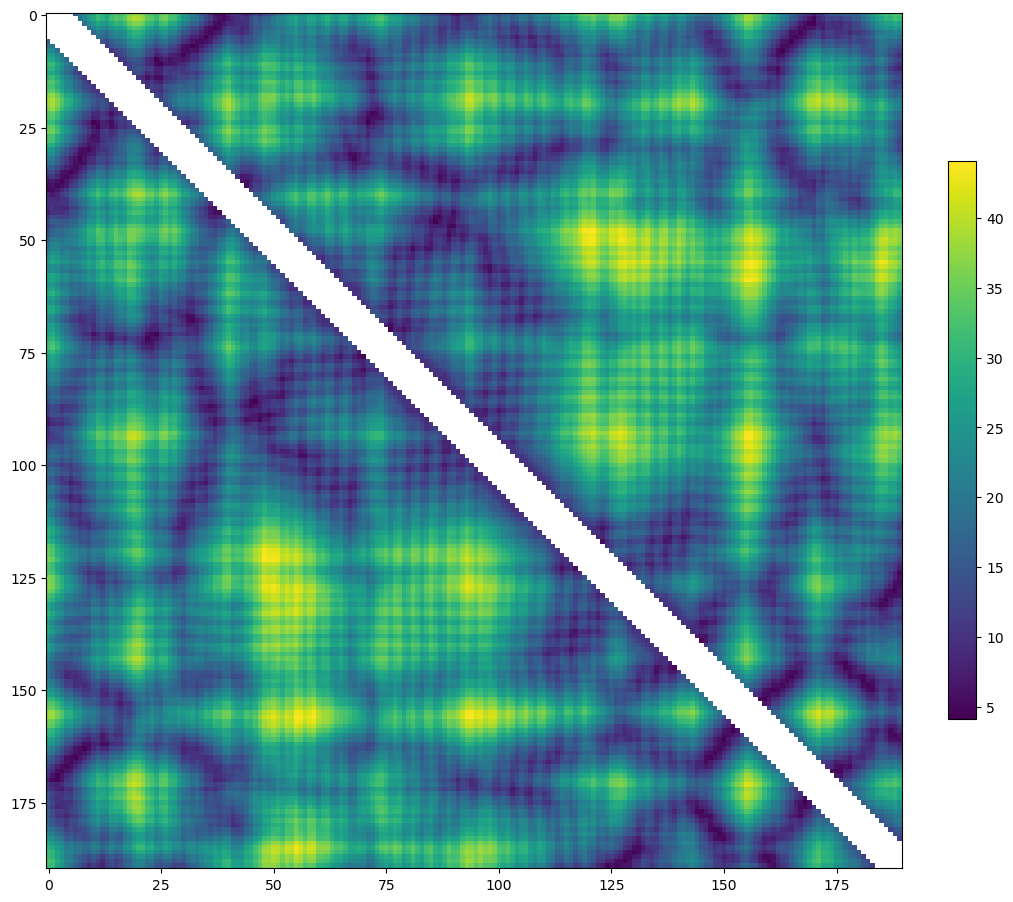

In [5]:
# Plot distance matrix

# Alter the color map to highlight nan values (the diagonal)
current_cmap = copy.copy(matplotlib.cm.get_cmap())
current_cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(dist_matrix)
fig.colorbar(im, fraction=0.03, pad=0.05)
plt.savefig(path + '/figures/ca_distances_{}.png'.format(pdb_id), dpi=300, bbox_inches='tight')

# Contact map

In [6]:
# Calculate the contact map based on a distace threshold 8 Angstrom
# Create a mask of the distance matrix based on a filter and cast to float
contact_map = (dist_matrix[:] < 8).astype(float)  
contact_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

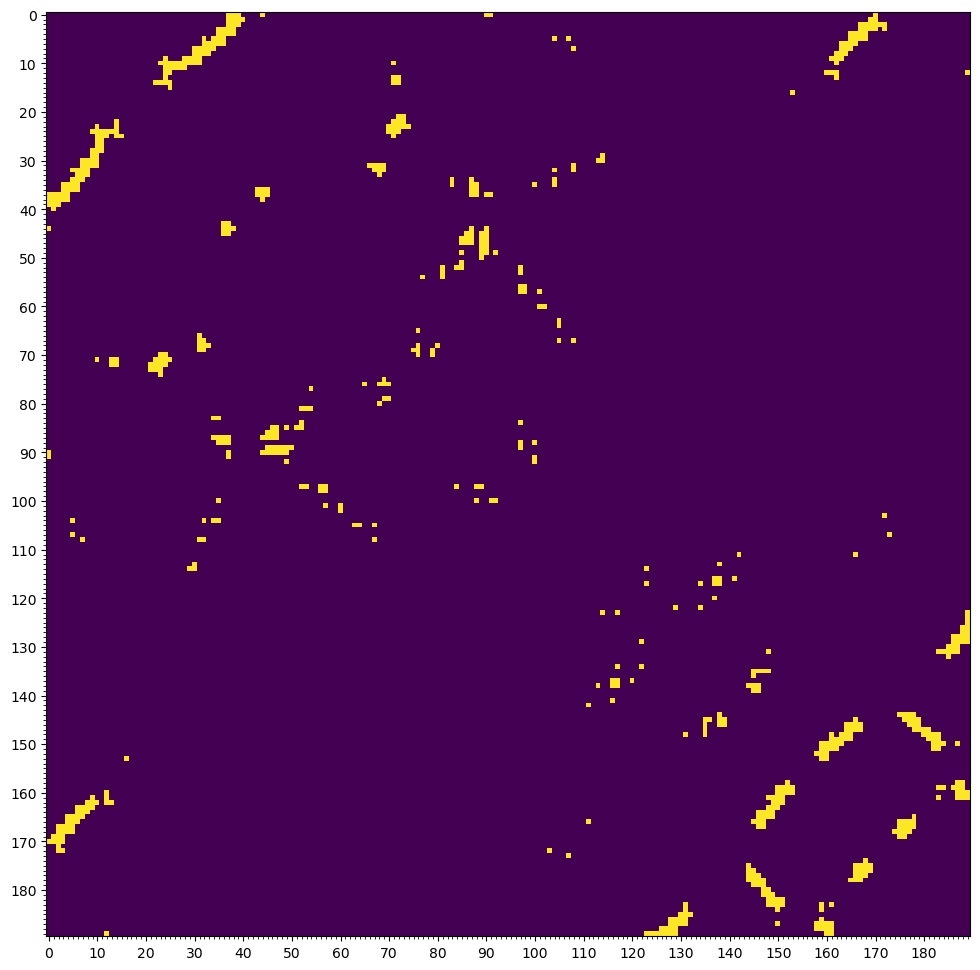

In [7]:
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}.png'.format(pdb_id), dpi=300, bbox_inches='tight')

# Contact map (NeighborSearch)

In [8]:
# Calculate the contact map using the NeighborSearch module (fast)
# https://biopython.org/docs/1.75/api/Bio.PDB.NeighborSearch.html

# Input
pdb_id = '1ucd'

# Fetch a PDB file to the current dir
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, pdir=path + "/pdb", file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "/pdb/pdb{}.ent".format(pdb_id))

# Select chain A of first model (0) and exclude hetero and water groups
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "]  

# Calculate contacts
ns = NeighborSearch([atom for residue in selected_residues for atom in residue.get_atoms()])

# Init a empty matrix
contact_map_nb = np.zeros((len(selected_residues), len(selected_residues)))

# "search_all" returns the list of atoms in contact based on a distance cutoff
# level="R" returns pairs of residues instead of atoms
for residue1, residue2 in ns.search_all(3.5, level="R"):
  # Sequence separation >= 6
  if abs(residue1.id[1] - residue2.id[1]) >= 6:
    contact_map_nb[selected_residues.index(residue1), selected_residues.index(residue2)] = 1
    # Add also the other part of the matrix
    contact_map_nb[selected_residues.index(residue2), selected_residues.index(residue1)] = 1
contact_map_nb

Structure exists: '../pdb/pdb1ucd.ent' 


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

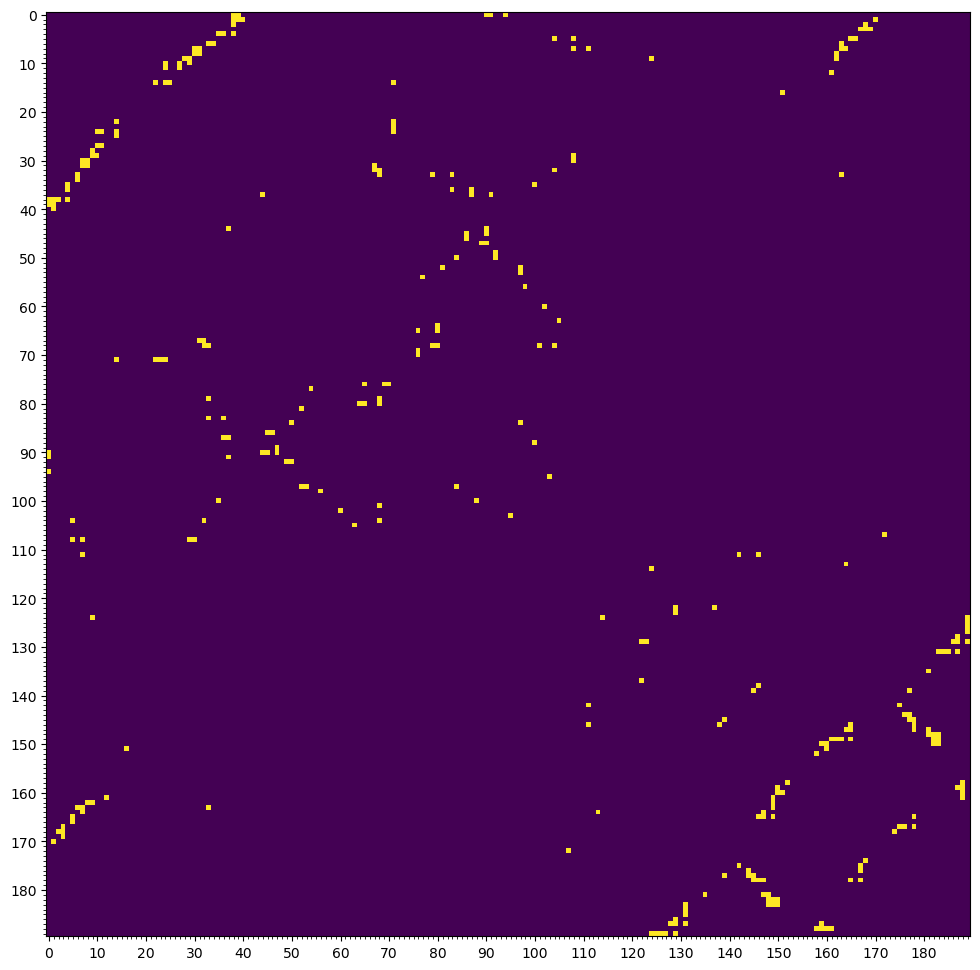

In [9]:
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/all_contacts_{}.png'.format(pdb_id), dpi=300, bbox_inches='tight')

# Compare contact maps

In [10]:
pdbl = PDBList()

# Input
pdb_ids = ['1ucd', '1ioo']

pdbl.download_pdb_files(pdb_ids, pdir=path + "/pdb", file_format='pdb')

structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "/pdb/pdb{}.ent".format(pdb_ids[0]))
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "]
dist_matrix = get_distance_matrix(selected_residues, seq_sep=0)

structure = PDBParser(QUIET=True).get_structure(pdb_id, path +"/pdb/pdb{}.ent".format(pdb_ids[1]))
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "]
dist_matrix2 = get_distance_matrix(selected_residues, seq_sep=0)

Structure exists: '../pdb/pdb1ucd.ent' 


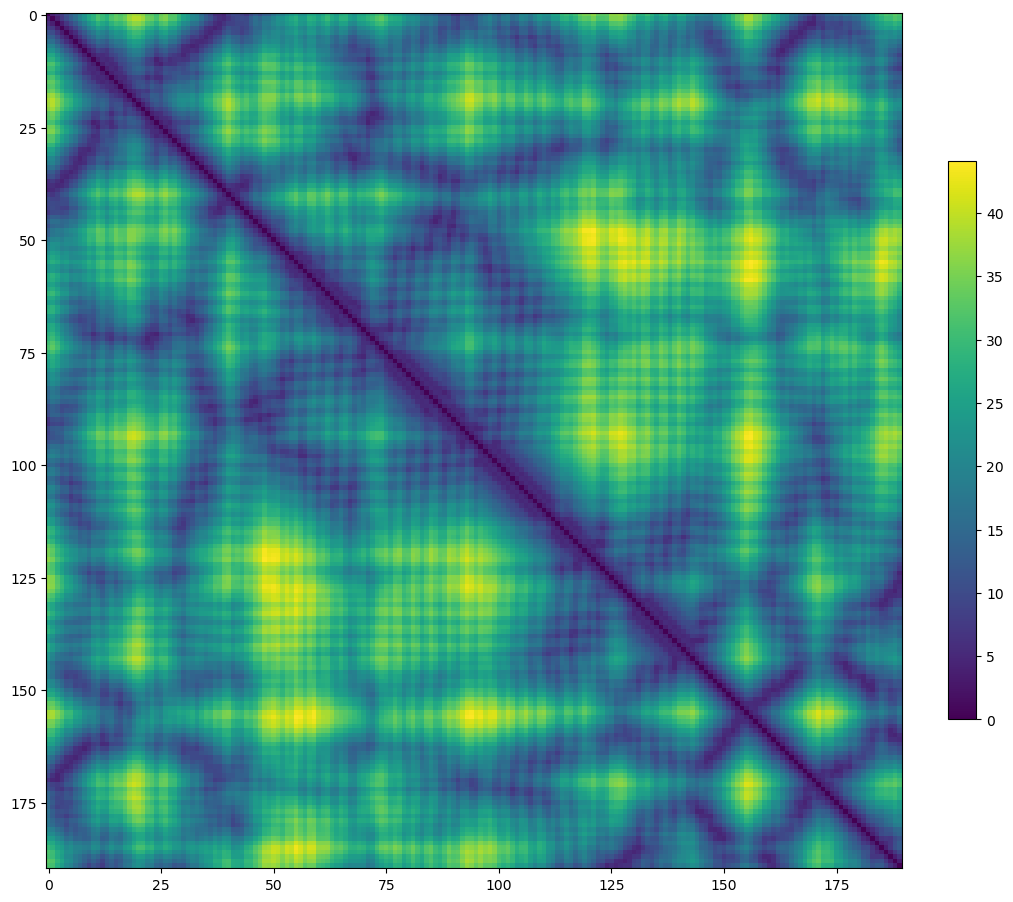

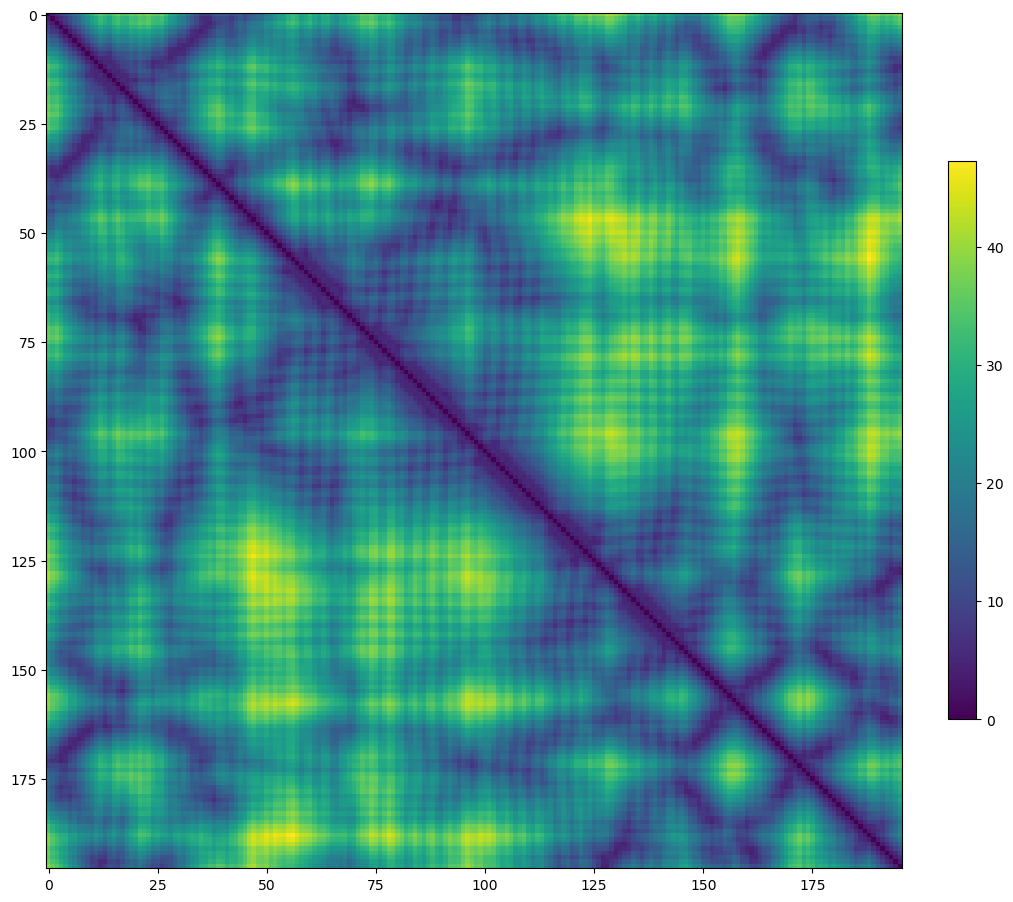

In [11]:
# Plot distance matrix
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(dist_matrix)
fig.colorbar(im, fraction=0.03, pad=0.05)

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(dist_matrix2)
fig.colorbar(im, fraction=0.03, pad=0.05)

In [12]:
# Align contact maps / distance matrices (cross-correlation)
# https://stackoverflow.com/questions/59651335/aligning-two-binary-matrices-for-maximum-overlap

# Replace NaN inplace (not necessary if sequence separation threshold is set to 0)
np.nan_to_num(dist_matrix, copy=False, nan=0.0)
np.nan_to_num(dist_matrix2, copy=False, nan=0.0)

# Contact maps
contact_matrix = (dist_matrix[:] < 8).astype(float)  
contact_matrix2 = (dist_matrix2[:] < 8).astype(float)

# Cross correlation
# Check distance matrix has diagonals, otherwise cross correlation fail
corr = scipy.signal.correlate2d(contact_matrix2, contact_matrix, mode="same") 

# Convolution
# corr = scipy.signal.convolve2d(contact_matrix2, contact_matrix)  
# print(corr)

# Find which is the maximum correlation 
# and which is the point where the two matrices reach this value
y, x = np.unravel_index(np.argmax(corr), corr.shape)  
print(corr.max())
print(x, y)

1448.0
95 95


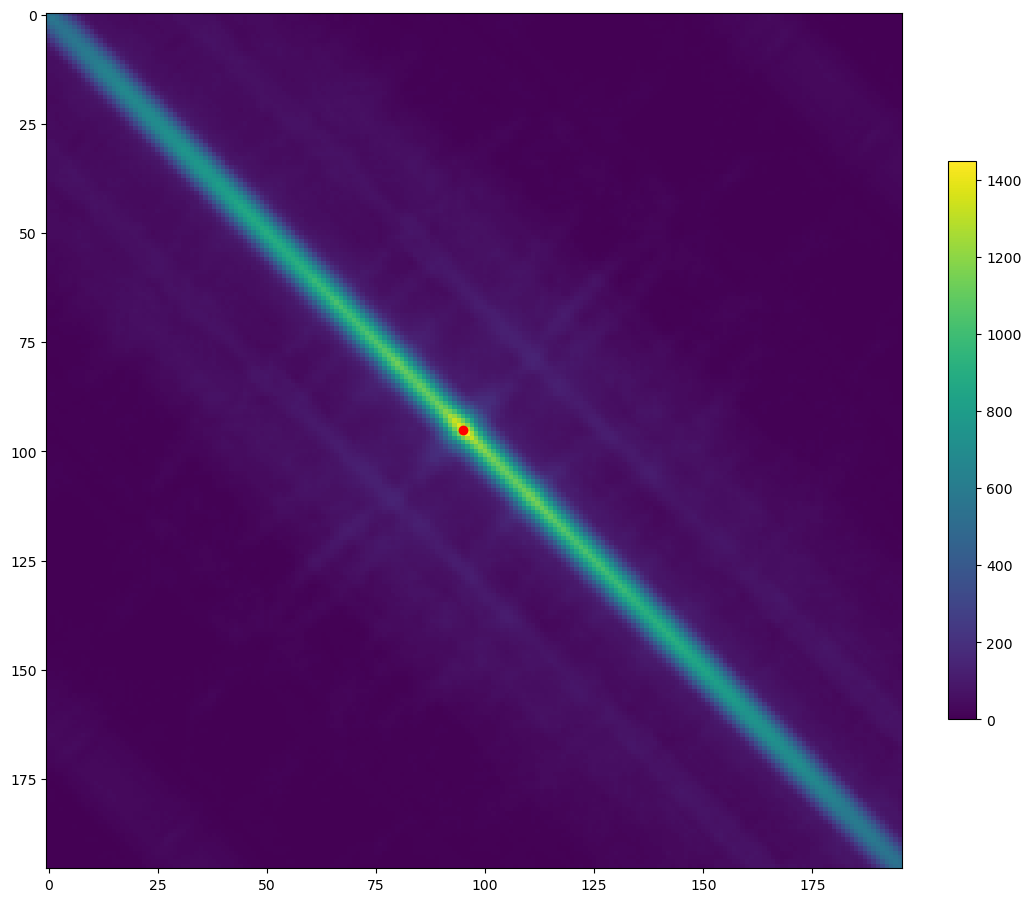

In [13]:
# Plot cross-correlation
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(corr)
ax.scatter([x], [y], color='red')
fig.colorbar(im, fraction=0.03, pad=0.05)

136.0
111 95


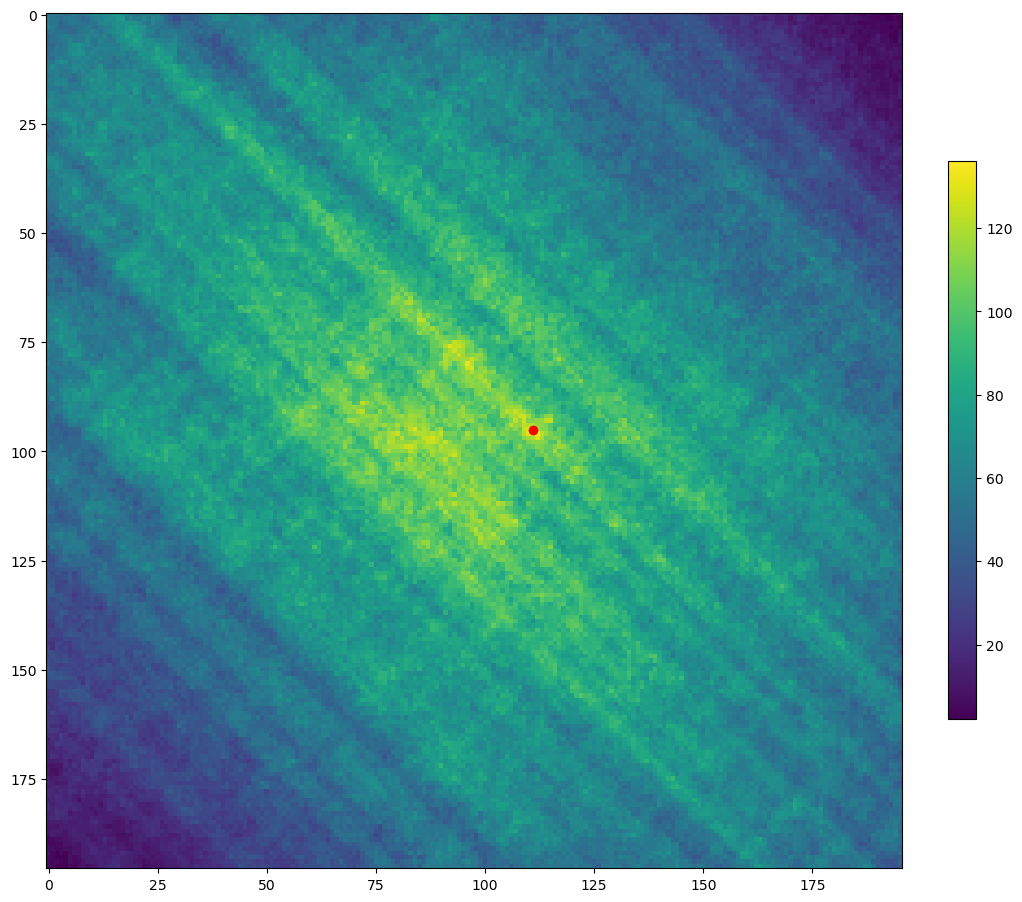

In [14]:
# Plot cross-correlation with one random matrix

# Randomize the first matrix
random_matrix = np.copy(contact_matrix) #first copy the contact map in a new variable
np.random.shuffle([np.random.shuffle(c) for c in random_matrix]) #shuffle the matrix

corr_random = scipy.signal.correlate2d(contact_matrix2, random_matrix, mode="same")  # cross correlation random
y, x = np.unravel_index(np.argmax(corr_random), corr_random.shape)  # find the match
print(corr_random.max())
print(x, y)

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(corr_random)
ax.scatter([x], [y], color='red')
fig.colorbar(im, fraction=0.03, pad=0.05)